In [28]:
import os
from os import path
import numpy as np
import nibabel as nib
from tqdm import tqdm
from torch.utils.data import Dataset
from glob import glob
import random
import torch
import torchio as tio
import matplotlib.pyplot as plt
from dataset_tio import *
import torchvision
from generator import GeneratorRRDB
from trainer_org import LitTrainer as LitTrainer_org
from trainer_gan import LitTrainer as LitTrainer_gan
# from trainer_tune import LitTrainer as LitTrainer_tune
import pytorch_lightning as pl
from discriminator import Discriminator
from feature_extractor import FeatureExtractor

print(os.getcwd())

/mnt/beta/djboonstoppel/Code


In [2]:
%load_ext autoreload
%autoreload 2

In [35]:
generator = GeneratorRRDB(channels=1, filters=64, num_res_blocks=1)
# discriminator = Discriminator(input_shape=(1, 64, 64))
feature_extractor = FeatureExtractor()

In [10]:
test_subjects = data_split('test', patients_frac=1)

std = 0.3548

test_set = tio.SubjectsDataset(
    test_subjects, transform=Normalize(std=std))



Loading test set...


Loading real dataset...


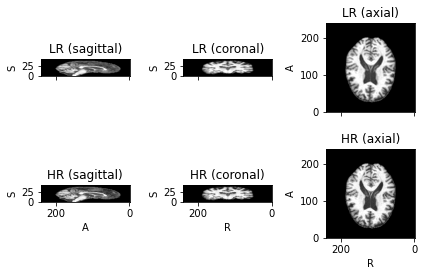

In [11]:
real_subjects = real_data()

std = 0.3548

transform = tio.Compose([
    Normalize(std=std),
    # tio.CropOrPad((224,224,45))
])


real_set = tio.SubjectsDataset(
    real_subjects, transform=transform)

real_set[0].plot()
# print(real_set)
# print(real_subjects)
# print(real_subjects[0])
# print(real_subjects[0]['HR'])
# print(real_subjects[0]['HR'].numpy())

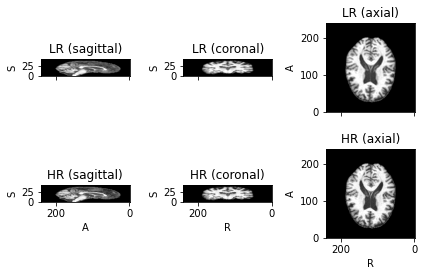

1267.0
1138.0


In [29]:
img = ImagePair(number=1, simulated=False, select_slices=45)
# img.subject()['HR']
# img.info()['HR']

real_subject = [img.subject()]

std = 0.3548

real_set = tio.SubjectsDataset(
    real_subject, transform=Normalize(std=std))

real_set[0].plot()

print(img.info()['LR']['scaling'])
print(img.info()['HR']['scaling'])
# print(real_set)
# print(real_subject)
# print(real_subject[0])
# print(real_subject[0]['HR'])
# print(real_subject[0]['HR'].numpy())

In [36]:
ckptpath='/mnt/beta/djboonstoppel/Code/log'
exp_name = 'patch-64'
# config = {
#     'learning_rate': 0.0001,
#     'patch_size': 224,
#     'batch_size': 16,
#     'patients_frac': 0.5,
#     'patch_overlap': 0.5,
#     'optimizer': 'adam',
#     'edge_loss': 2,
# }
# ckpt_filename = 'checkpoint_{}_{}_{}_{}_{}_{}'.format(config['patch_size'],
#                                                       config['batch_size'],
#                                                       config['patients_frac'],
#                                                       config['edge_loss'],
#                                                       config['optimizer'],
#                                                       config['learning_rate'],
#                                                       )

ckpt_filename = exp_name + '-checkpoint'


model = LitTrainer_org.load_from_checkpoint(netG=generator,
                                            netF=feature_extractor,
                                            # netD=discriminator,
                                            # netF=feature_extractor,
                                            checkpoint_path=os.path.join(ckptpath, exp_name, ckpt_filename+'.ckpt'))
print(model.hparams)
model.eval()
model.freeze()


RuntimeError: Error(s) in loading state_dict for LitTrainer:
	Missing key(s) in state_dict: "netF.vgg19_54.0.weight", "netF.vgg19_54.0.bias", "netF.vgg19_54.2.weight", "netF.vgg19_54.2.bias", "netF.vgg19_54.5.weight", "netF.vgg19_54.5.bias", "netF.vgg19_54.7.weight", "netF.vgg19_54.7.bias", "netF.vgg19_54.10.weight", "netF.vgg19_54.10.bias", "netF.vgg19_54.12.weight", "netF.vgg19_54.12.bias", "netF.vgg19_54.14.weight", "netF.vgg19_54.14.bias", "netF.vgg19_54.16.weight", "netF.vgg19_54.16.bias", "netF.vgg19_54.19.weight", "netF.vgg19_54.19.bias", "netF.vgg19_54.21.weight", "netF.vgg19_54.21.bias", "netF.vgg19_54.23.weight", "netF.vgg19_54.23.bias", "netF.vgg19_54.25.weight", "netF.vgg19_54.25.bias", "netF.vgg19_54.28.weight", "netF.vgg19_54.28.bias", "netF.vgg19_54.30.weight", "netF.vgg19_54.30.bias", "netF.vgg19_54.32.weight", "netF.vgg19_54.32.bias", "netF.vgg19_54.34.weight", "netF.vgg19_54.34.bias". 

In [32]:
batch_size = model.hparams.config['batch_size']

patch_size = (model.hparams.config['patch_size'],model.hparams.config['patch_size'])
ovl_perc = (model.hparams.config['patch_overlap'], model.hparams.config['patch_overlap'])
overlap, nr_patches = calculate_overlap(real_subject[0]['LR'], patch_size, ovl_perc)

AttributeError: 'FeatureExtractor' object has no attribute 'hparams'

In [11]:
subject = real_set[0]
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size=(*patch_size,1),
    patch_overlap=overlap,
    padding_mode=0,
)

patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=model.hparams.config['batch_size'])

In [34]:
# patch_loader = torch.utils.data.DataLoader(
#     grid_sampler, batch_size=model.hparams.config['batch_size'])
#
# with torch.no_grad():
#     for i, patches_batch in enumerate(patch_loader):
#         if i == 2:
#             imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['HR'][tio.DATA].squeeze(4)
#             gen_hr = model(imgs_lr)
# # grid = torch.cat([torch.stack([a*std,b*std,c*std])
# #                   for a,b,c in zip(imgs_lr[120:125],imgs_hr[120:125],gen_hr[120:125])])
# grid = torch.cat([torch.stack([a*std,b*std,c*std])
#                   for a,b,c in zip(imgs_lr[:5],imgs_hr[:5],gen_hr[:5])])
# grid_img = torchvision.utils.make_grid(grid, nrow=3)
# plt.figure(figsize=(10,30))
# plt.imshow(grid_img.permute(1, 2, 0))

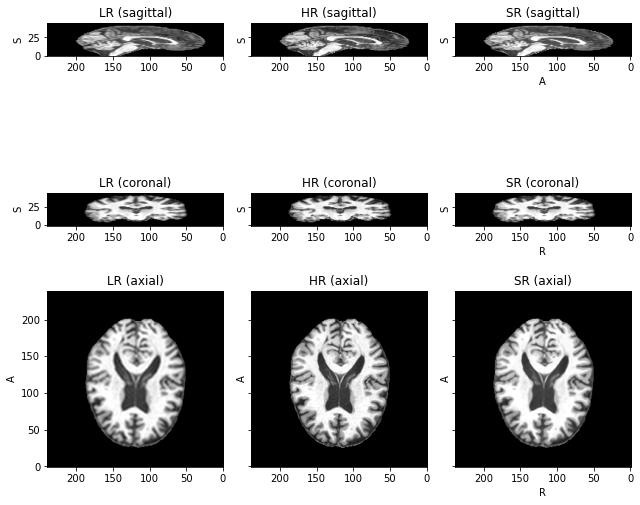

In [12]:
aggregator = tio.inference.GridAggregator(grid_sampler)#, overlap_mode='average')
model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['HR'][tio.DATA].squeeze(4)
        gen_hr = model(imgs_lr).unsqueeze(4)
        locations = patches_batch[tio.LOCATION]
        aggregator.add_batch(gen_hr, locations)

foreground = aggregator.get_output_tensor()
generated = tio.ScalarImage(tensor=foreground)
subject.add_image(generated, 'SR')
subject.plot(figsize=(9, 8))

In [18]:
config = model.hparams.config
# img_name = 'gen_{}_{}_{}_{}_{}_{}_{}'.format(config['patch_size'],
#                                           config['batch_size'],
#                                           config['patients_frac'],
#                                           config['edge_loss'],
#                                           config['optimizer'],
#                                           # config['learning_rate'],
#                                           config['content'],
#                                           config['adversarial'],
#                                           )

# img_name = 'real_gen_{}'.format(config['patch_size'])
# subject['gen_hr'].save(os.path.join('output', img_name+'_2.dcm'))
# subject['gen_hr'].save(os.path.join('output'))#, img_name+'_2.dcm'))

ImageFileError: 

In [13]:
def re_scale(img, std, perc):
    img *= std
    min_val, max_val = perc
    img = (img * (max_val - min_val)) + min_val
    return img

def save_to_nifti(img, header, fname, std, perc):
    img = img.numpy()[0]
    img = re_scale(img, std, perc)
    img_nifti = nib.Nifti1Image(img, affine=np.eye(4), header=header)
    nib.save(img_nifti, fname)

def save_subject(subject, header, pref, std, percs, path='output'):
    save_to_nifti(img = subject['LR'],
                  header = header,
                  std = std,
                  perc = percs[0],
                  fname = os.path.join(path, '{}_LR'.format(pref)),
                  )
    save_to_nifti(img = subject['HR'],
                  header = header,
                  std = std,
                  perc = percs[1],
                  fname = os.path.join(path, '{}_HR'.format(pref)),
                  )
    save_to_nifti(img = subject['SR'],
                  header = header,
                  std = std,
                  perc = percs[2],
                  fname = os.path.join(path, '{}_SR'.format(pref)),
                  )

In [15]:
# gen_hr = subject['SR'].numpy()[0]
# gen_hr_nifty = nib.Nifti1Image(gen_hr, affine=img.subject()['HR'].affine, header=img.info()['HR'])
# nib.save(gen_hr_nifty, 'test.nii.gz')

name='test_1'
std = std
percs = (
    img.info()['LR'][1],
    img.info()['HR'][1],
    img.info()['LR'][1],
    )
save_subject(subject=subject,
             header=img.info()['HR'][0],
             pref=name,
             std=std,
             percs=percs,
             )

In [8]:
test = np.arange(0,101)
perc = 95
max_val = np.percentile(test, perc)
test_norm = test/max_val

# test_norm = ((test.astype(float) - min_val) / (max_val - min_val)).astype(np.float32)
print(test)
print(test.mean())
print(max_val)
print(test_norm)
print(test_norm.mean())

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]
50.0
95.0
[0.         0.01052632 0.02105263 0.03157895 0.04210526 0.05263158
 0.06315789 0.07368421 0.08421053 0.09473684 0.10526316 0.11578947
 0.12631579 0.13684211 0.14736842 0.15789474 0.16842105 0.17894737
 0.18947368 0.2        0.21052632 0.22105263 0.23157895 0.24210526
 0.25263158 0.26315789 0.27368421 0.28421053 0.29473684 0.30526316
 0.31578947 0.32631579 0.33684211 0.34736842 0.35789474 0.36842105
 0.37894737 0.38947368 0.4        0.41052632 0.42105263 0.43157895
 0.44210526 0.45263158 0.46315789 0.47368421 0.48421053 0.49473684
 0.50526316 0.51578947 0.52631579 0.5368421

In [9]:
test_rescaled = test_norm * max_val
print(test_rescaled)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100.]


In [26]:
import torch.nn as nn
from torchvision.models import vgg19
from torchsummary import summary


class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.vgg19_54 = nn.Sequential(*list(vgg19_model.features.children())[:35])

    def forward(self, img):
        return self.vgg19_54(img)

In [27]:
model = FeatureExtractor().cuda()
summary(model, (3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,